In [119]:
from utils import *
from MySolution import MyClassifier, MyClustering, MyLabelSelection
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
import cvxopt as cvx
import cvxpy as cp
from pulp import LpVariable, LpProblem, LpMinimize
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [120]:
# def prepare_synthetic_data():
#     data = dict()

#     X = np.loadtxt('Data/synthetic/synthetic_X.csv', delimiter=',').reshape(1500, 2)
#     Y = np.loadtxt('Data/synthetic/synthetic_Y.csv', delimiter=',')

#     data['trainX'] = X[:1000]  # 1000 x 2
#     data['trainY'] = Y[:1000]  # 1000 x 1
#     data['testX']  = X[1000:]  # 500 x 2
#     data['testY']  = Y[1000:]  # 500 x 1
 
#     return data


# def prepare_mnist_data():
#     data = dict()

#     X = np.loadtxt('Data/reduced_mnist/mnist_X.csv', delimiter=',').reshape(1500, 784)
#     Y = np.loadtxt('Data/reduced_mnist/mnist_Y.csv', delimiter=',')

#     data['trainX'] = X[:1000]  # 1000 x 784
#     data['trainY'] = Y[:1000]  # 1000 x 1
#     data['testX']  = X[1000:]  # 500 x 784
#     data['testY']  = Y[1000:]  # 500 x 1

#     return data


In [121]:
# def plot_result(result1 = None, result2 = None, result3 = None):
#     ''' Input Format with Examples:
#         from Task1: result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}

#         from Task2: result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[0.6,0.6,0.6], 'classification_accuracy':[0.8,0.8,0.8]},
#             'mnist':{'K':[3, 10, 32], 'clustering_nmi':[0.5,0.5,0.5], 'classification_accuracy':[0.7,0.7,0.7]}}
                                
#         from Task3: result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.6,0.7,0.8,0.9], 'test_accuracy(random)':[0.4,0.5,0.6,0.7,0.8]},
#             'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'test_accuracy(random)':[0.4,0.4,0.6,0.6,0.6]}}
#     '''

#     if result1 != None and result2 != None:
#         x1 = [-0.4,0,0.4]
#         x2 = [1,1.4,1.8]
#         width = 0.35

#         plt.bar(x1, result2['synthetic']['clustering_nmi'], width)
#         for i in range(3):
#             plt.text(x1[i], result2['synthetic']['clustering_nmi'][i]/2, 'K={}'.format(result2['synthetic']['K'][i]), fontsize=12, ha='center', bbox = dict(facecolor = 'white', alpha = .8))
#         plt.bar(x2, result2['mnist']['clustering_nmi'], width)
#         for i in range(3):
#             plt.text(x2[i], result2['mnist']['clustering_nmi'][i]/2, 'K={}'.format(result2['mnist']['K'][i]), fontsize=12, ha='center', bbox = dict(facecolor = 'white', alpha = .8))
#         plt.ylim(0,1)
#         plt.xticks([0,1.3], ['Synthetic', 'MNIST'], fontsize=12)
#         plt.ylabel('NMI', fontsize=12)
#         plt.xlabel('Dataset', fontsize=12)
#         plt.title("Clustering Performance on training data", fontsize=14)
#         plt.show()


#         plt.bar(x1, result2['synthetic']['classification_accuracy'], width)
#         for i in range(3):
#             plt.text(x1[i], result2['synthetic']['classification_accuracy'][i]/2, 'K={}'.format(result2['synthetic']['K'][i]), fontsize=12, ha='center', bbox = dict(facecolor = 'white', alpha = .8))
#         plt.bar(x2, result2['mnist']['classification_accuracy'], width)
#         for i in range(3):
#             plt.text(x2[i], result2['mnist']['classification_accuracy'][i]/2, 'K={}'.format(result2['mnist']['K'][i]), fontsize=12, ha='center', bbox = dict(facecolor = 'white', alpha = .8))

#         plt.ylim(0,1)
#         plt.xticks([0,1.3], ['Synthetic', 'MNIST'], fontsize=12)
#         plt.axhline(y=0.97, color='blue', linestyle='--', linewidth=2, label = 'supervised (Synthetic)')
#         plt.axhline(y=result1['mnist_test_accuracy'], color='orange', linestyle='--', linewidth=2, label = 'supervised (MNIST)')
#         plt.legend(bbox_to_anchor=(1, 1))
#         plt.title("Classification Performance on testing data", fontsize=14)
#         plt.ylabel('Test Accuracy', fontsize=12)
#         plt.xlabel('Dataset', fontsize=12)
#         plt.show()
    

#     if result3 != None: 
#         plt.plot(result3['synthetic']['label_percentage'], result3['synthetic']['test_accuracy(our algo)'], label='our algo', marker='x', markersize=8)
#         plt.plot(result3['synthetic']['label_percentage'], result3['synthetic']['test_accuracy(random)'], label='random selection', marker='o', markersize=8)
#         plt.ylim(0,1)
#         plt.legend()
#         plt.xlabel("Label Percentage", fontsize=12) 
#         plt.ylabel('Test Accuracy', fontsize=12)
#         plt.title("Label Selection on Synthetic Data", fontsize=14)
#         plt.show()

#         plt.plot(result3['mnist']['label_percentage'], result3['mnist']['test_accuracy(our algo)'], label='our algo', marker='x', markersize=8,linewidth=2)
#         plt.plot(result3['mnist']['label_percentage'], result3['mnist']['test_accuracy(random)'], label='random selection', marker='o', markersize=8, linewidth=2)
#         plt.ylim(0,1)
#         plt.legend()
#         plt.xlabel("Label Percentage", fontsize=12) 
#         plt.ylabel('Test Accuracy', fontsize=12)
#         plt.title("Label Selection on MNIST Data", fontsize=14)
#         plt.show()



In [122]:
from cvxopt import spmatrix, matrix, solvers
solvers.options['show_progress'] = False  
# solvers.options["show_progress"] = True

In [123]:
# class MyClustering:
    
#     def __init__(self, K):
        
#         self.K = K  # number of classes
#         self.labels = None
#         self.cluster_centers_ = None
        
#         ### TODO: Initialize other parameters needed in your algorithm
#         # examples: 
#         # self.cluster_centers_ = None
#     def train(self, trainX):
#         N, d = trainX.shape
#         tolerance = 1e-3  # Set the tolerance value

#         # Initialize cluster centers by randomly choosing K data points from trainX
#         random_indices = np.random.choice(N, self.K, replace=False)
#         self.cluster_centers_ = trainX[random_indices, :]

#         iteration = 0
#         while iteration < 100:
#             # Flatten cluster centers to use in the optimization
#             flat_centers = self.cluster_centers_.flatten()

#             # Linear programming formulation for clustering
#             c = np.ones(N * self.K)
#             A_eq = np.zeros((N, N * self.K))
#             for i in range(N):
#                 A_eq[i, i * self.K: (i + 1) * self.K] = 1
#             b_eq = np.ones(N)
#             bounds = [(0, 1) for _ in range(N * self.K)]

#             # Solve the linear programming problem
#             result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
#             # print(result.x.shape)
#             new_labels = np.argmax(result.x.reshape(N, self.K), axis=1)

#             # Check for convergence based on tolerance
#             if np.array_equal(new_labels, self.labels):
#                 print("Converged.",iteration)
#                 break

#             # Update cluster centers based on the new assignments
#             self.labels = new_labels
#             self.cluster_centers_ = np.array([np.mean(trainX[self.labels == k], axis=0) for k in range(self.K)])

#             iteration += 1

#         return self.labels



    
#     def infer_data_labels(self, testX):
#         ''' Task 2-2 
#             TODO: assign new data points to the existing clusters
            
#         '''
#         if self.cluster_centers_ is None:
#             raise ValueError("Model not trained. Please call train() first.")

#         # Assign each data point to the nearest cluster
#         pred_labels = np.argmin(np.linalg.norm(testX[:, np.newaxis, :] - self.cluster_centers_, axis=2), axis=1)

        

#         # Return the cluster labels of the input data (testX)
#         return pred_labels
    

#     def evaluate_clustering(self, trainY):
#         label_reference = self.get_class_cluster_reference(self.labels, trainY)
#         aligned_labels = self.align_cluster_labels(self.labels, label_reference)
#         nmi = normalized_mutual_info_score(trainY, aligned_labels)

#         return nmi
    

#     def evaluate_classification(self, trainY, testX, testY):
#         pred_labels = self.infer_data_labels(testX)
#         label_reference = self.get_class_cluster_reference(self.labels, trainY)
#         aligned_labels = self.align_cluster_labels(pred_labels, label_reference)
#         accuracy = accuracy_score(testY, aligned_labels)

#         return accuracy


#     def get_class_cluster_reference(self, cluster_labels, true_labels):
#         ''' assign a class label to each cluster using majority vote '''
#         label_reference = {}
#         for i in range(len(np.unique(cluster_labels))):
#             index = np.where(cluster_labels == i,1,0)
#             num = np.bincount(true_labels[index==1]).argmax()
#             label_reference[i] = num

#         return label_reference
    
    
#     def align_cluster_labels(self, cluster_labels, reference):
#         ''' update the cluster labels to match the class labels'''
#         aligned_lables = np.zeros_like(cluster_labels)
#         for i in range(len(cluster_labels)):
#             aligned_lables[i] = reference[cluster_labels[i]]

#         return aligned_lables


Synthetic data shape:  (1200, 2) (1200,)


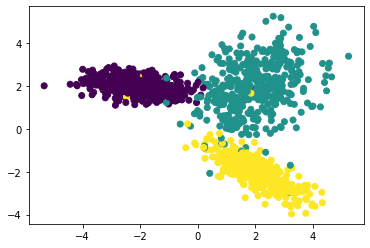

In [124]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

MNIST data shape:  (1000, 784) (1000,)


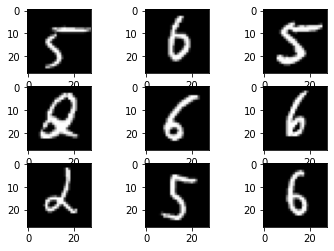

In [125]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

In [126]:
syn_nmi=[]
syn_acc=[]
mini_nmi=[]
mini_acc=[]

In [127]:
## TODO: Implement your solution and store the results in the following dictionaries
## Please note that the below values are given as an example to show the format, 
## you need to replace them with your values :)
k=MyClustering(K=3)
la=k.train(syn_data['trainX'])
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(syn_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))
syn_nmi.append(k.evaluate_clustering(syn_data['trainY'].astype(int)))
syn_acc.append(k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))
# my_result=k_cluster.evaluate_clustering(syn_data['trainY'])

# result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}

# result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[0.6,0.6,0.6], 'classification_accuracy':[0.8,0.8,0.8]},
#             'mnist':{'K':[3, 10, 32], 'clustering_nmi':[0.5,0.5,0.5], 'classification_accuracy':[0.7,0.7,0.7]}}
                                
# result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.6,0.7,0.8,0.9], 'test_accuracy(random)':[0.4,0.5,0.6,0.7,0.8]},
#             'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'test_accuracy(random)':[0.4,0.4,0.6,0.6,0.6]}}


# plot_result(result1, result2, result3)

TypeError: __init__() missing 1 required positional argument: 'myk'

In [ ]:
k=MyClustering(K=5)
la=k.train(syn_data['trainX'])
# print(k.labels)
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(syn_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))
syn_nmi.append(k.evaluate_clustering(syn_data['trainY'].astype(int)))
syn_acc.append(k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))

Converged. 1



nim: 0.0037225416263362023



acc: 0.702


In [ ]:
k=MyClustering(K=10)
la=k.train(syn_data['trainX'])
# print(k.labels)
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(syn_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))
syn_nmi.append(k.evaluate_clustering(syn_data['trainY'].astype(int)))
syn_acc.append(k.evaluate_classification(syn_data['trainY'].astype(int), syn_data['testX'].astype(int), syn_data['testY'].astype(int)))

Converged. 1



nim: 0.007295479809290849



acc: 0.92


In [ ]:
k=MyClustering(K=3)
la=k.train(mnist_data['trainX'])
# print(k.labels)
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(mnist_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))
mini_nmi.append(k.evaluate_clustering(mnist_data['trainY'].astype(int)))
mini_acc.append(k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))

Converged. 1



nim: 0.0



acc: 0.302


In [ ]:
k=MyClustering(K=10)
la=k.train(mnist_data['trainX'])
# print(k.labels)
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(mnist_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))
mini_nmi.append(k.evaluate_clustering(mnist_data['trainY'].astype(int)))
mini_acc.append(k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))

Converged. 1



nim: 0.0032257749162201577



acc: 0.444


In [ ]:
k=MyClustering(K=32)
la=k.train(mnist_data['trainX'])
# print(k.labels)
# print(syn_data['trainY'].astype(int))
print("\n\n\nnim:",k.evaluate_clustering(mnist_data['trainY'].astype(int)))

print("\n\n\nacc:",k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))
mini_nmi.append(k.evaluate_clustering(mnist_data['trainY'].astype(int)))
mini_acc.append(k.evaluate_classification(mnist_data['trainY'].astype(int), mnist_data['testX'].astype(int), mnist_data['testY'].astype(int)))

Converged. 1



nim: 0.01041003111548222



acc: 0.592


{'synthetic': {'K': [3, 5, 10], 'clustering_nmi': [0.0009698308725354794, 0.0037225416263362023, 0.007295479809290849], 'classification_accuracy': [0.536, 0.702, 0.92]}, 'mnist': {'K': [3, 10, 32], 'clustering_nmi': [0.0, 0.0032257749162201577, 0.01041003111548222], 'classification_accuracy': [0.302, 0.444, 0.592]}}


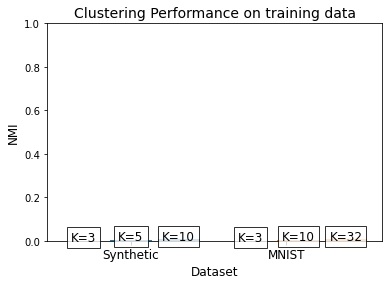

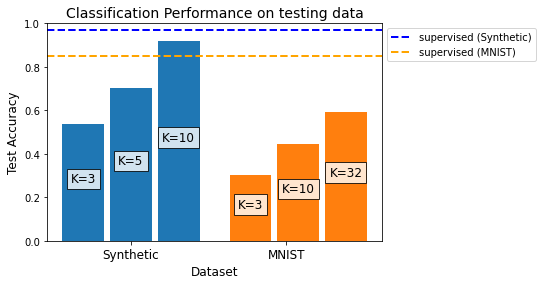

In [ ]:
result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':syn_nmi, 'classification_accuracy':syn_acc},
            'mnist':{'K':[3, 10, 32], 'clustering_nmi':mini_nmi, 'classification_accuracy':mini_acc}}
result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}
print(result2)
plot_result( result1,result2)